## **Assignment 6: t-SNE**

- Karyl Grasparil
- Mariah Anajanelle Quiquinto

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from tabulate import tabulate
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.patheffects import withStroke

##### 1. Data

a) Each row of csvImages 10k x 784.csv contains the gray scale values of a 28 x 28 image. Load this data into a pandas dataframe. Convert the dataframe to a numpy array using pandas.values. Print the shape of the data.

In [73]:
# Load the CSV file and convert it to a NumPy array
data = pd.read_csv('archive/csvTestImages 10k x 784.csv').values 

# Print the shape of the data
print("Shape of the data:", data.shape)

Shape of the data: (9999, 784)


b) Normalize by dividing each value by 255. In order to display the images, reshape the array so each image is 28 x 28 using numpy.ndarray.reshape. Use matplotlib.plot.imshow and matplotlib.plot.subplot to give a plot of the first five images using the 'gray' colour map. In order to put the data back in the original shape for input to the neural network, reshape each image to be 784 (one-dimensional). 

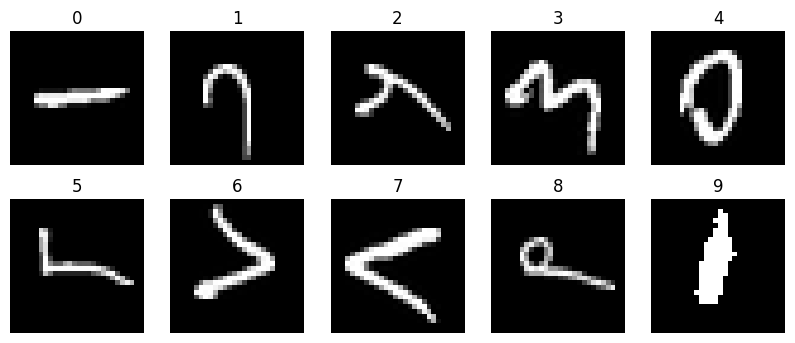

Shape of flattened data: (9999, 784)


In [74]:
# Normalize the data by dividing by 255
# Pixel values of the images are scaled from [0, 255] to [0, 1] for better convergence during training.
data_normalized = data / 255.0

# Reshape (NumPy array) the data for visualization (28x28 images)
# The data is reshaped from a 1D vector (784) back into its original 2D shape (28x28)
data_reshaped = data_normalized.reshape(-1, 28, 28) 

# Display 10 reconstructed images in a 2x5 grid
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data_reshaped[i], cmap='gray')
    plt.title(str(i))
    plt.axis('off')
plt.show()

# Reshape the images back to 784 for neural network input
data_flattened = data_reshaped.reshape(-1, 784)

# Print the shape to confirm it has been flattened correctly
print("Shape of flattened data:", data_flattened.shape)

#####  2. Clustering

a) Use sklearn.decomposition.PCA.fit_transform to do a PCA transformation with n_components = 40. This reduces the dimension of each image to a size that is more manageable, while keeping the most important aspects of the data.

In [75]:
# Perform PCA with n_components=40
pca = PCA(n_components=40)
data_pca = pca.fit_transform(data_flattened)

# Print the shape of the transformed data to confirm the dimensionality reduction
print("Shape of the data after PCA:", data_pca.shape)

Shape of the data after PCA: (9999, 40)


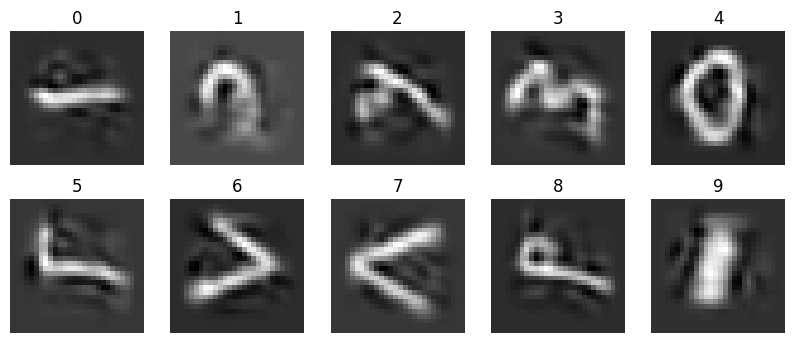

In [76]:
# Reconstruct images from the reduced PCA components
data_reconstructed = pca.inverse_transform(data_pca)
data_reconstructed_reshaped = data_reconstructed.reshape(-1, 28, 28)

# Display 10 reconstructed images in a 2x5 grid
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data_reconstructed_reshaped[i], cmap='gray')
    plt.title(str(i))
    plt.axis('off')
plt.show()


b) Create at least 8 different clustering models using k-means, (agglomerative and divisive) hierarchical, and DBSCAN clustering; experiment with different choices of hyperparameters. Calculate the silhouette score for each model and tabulate the results.

In [77]:
results = []

def evaluate_model(model_name, labels, data):
    silhouette = silhouette_score(data, labels)
    results.append({"Model": model_name, "Silhouette Score": silhouette})

# K-Means Clustering 
for k in (5, 10):
    kmeans = KMeans(n_clusters=k, n_init=10)
    labels = kmeans.fit_predict(data_pca)
    evaluate_model(f"KMeans (k={k})", labels, data_pca)

In [78]:
# Agglomerative Clustering
for n_clusters in (5, 10):  
    for linkage_method in ['ward', 'average', 'complete', 'single']:
        try:
            agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
            labels = agg.fit_predict(data_pca)
            score = silhouette_score(data_pca, labels)
            evaluate_model(f"Agglomerative ({linkage_method}, n_clusters={n_clusters})", labels, data_pca)
        except ValueError as e:
            print(f"Error with linkage={linkage_method} and n_clusters={n_clusters}: {e}")

In [79]:
# Divisive Clustering
Z = linkage(data_pca, method='ward')  
for n_clusters in (5, 10):  
    divisive_labels = fcluster(Z, n_clusters, criterion='maxclust')  # Cut the dendrogram
    evaluate_model(f"Divisive (ward, n_clusters={n_clusters})", divisive_labels, data_pca)

In [80]:
# DBSCAN Clustering
for eps in [0.5, 0.7, 1.0, 1.2]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(data_pca)
    if len(set(labels)) > 1:  # Only calculate silhouette if more than one cluster
        evaluate_model(f"DBSCAN (eps={eps})", labels, data_pca)

In [81]:
# Display clustering results
df_results = pd.DataFrame(results).sort_values(by="Silhouette Score", ascending=False)
print(tabulate(df_results, headers="keys", tablefmt="fancy_grid"))

╒════╤═════════════════════════════════════════╤════════════════════╕
│    │ Model                                   │   Silhouette Score │
╞════╪═════════════════════════════════════════╪════════════════════╡
│  3 │ Agglomerative (average, n_clusters=5)   │          0.193362  │
├────┼─────────────────────────────────────────┼────────────────────┤
│  4 │ Agglomerative (complete, n_clusters=5)  │          0.193202  │
├────┼─────────────────────────────────────────┼────────────────────┤
│  7 │ Agglomerative (average, n_clusters=10)  │          0.15887   │
├────┼─────────────────────────────────────────┼────────────────────┤
│  1 │ KMeans (k=10)                           │          0.121776  │
├────┼─────────────────────────────────────────┼────────────────────┤
│  0 │ KMeans (k=5)                            │          0.113028  │
├────┼─────────────────────────────────────────┼────────────────────┤
│  6 │ Agglomerative (ward, n_clusters=10)     │          0.108394  │
├────┼──────────────

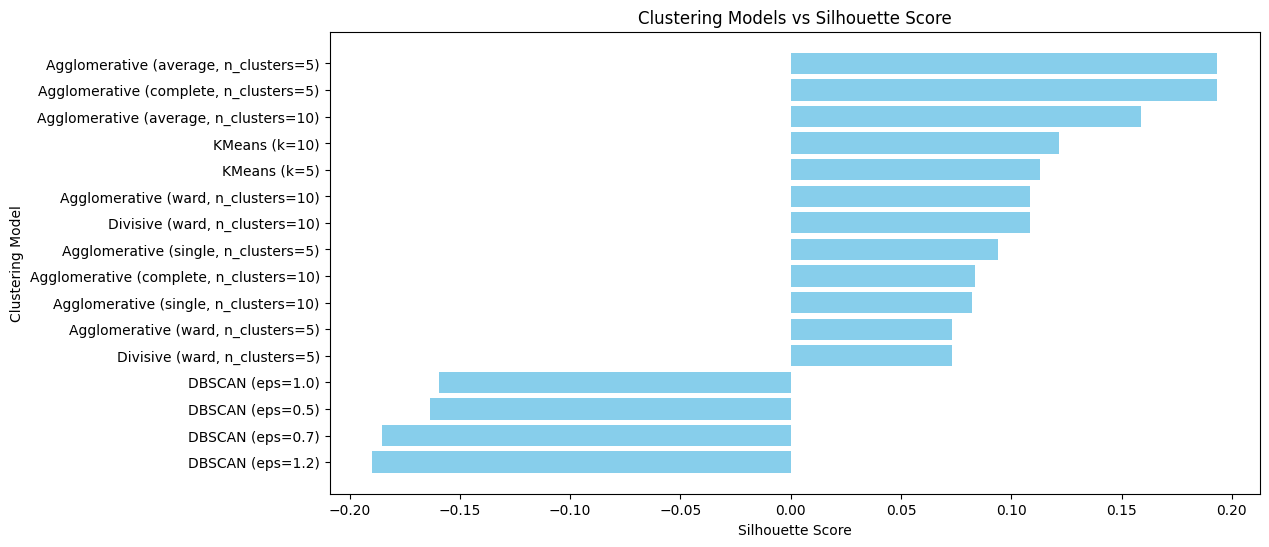

In [89]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.barh(df_results["Model"], df_results["Silhouette Score"], color='skyblue')
plt.xlabel("Silhouette Score")
plt.ylabel("Clustering Model")
plt.title("Clustering Models vs Silhouette Score")
plt.gca().invert_yaxis()  # Invert y-axis to show the best model on top
plt.show()

c) Select the best model for the use case and justify your choice in markdown.

<span style="color: green">

Among the various models tested, Agglomerative clustering with an average linkage and \( n\_clusters = 5 \) achieved the highest silhouette score of 0.193362. While this score is not particularly high, it may still indicate the presence of meaningful patterns, especially given the complexity of image data. The low silhouette scores across all models suggest that the data might not naturally divide into well-defined clusters. Additionally, selecting the best model solely based on silhouette scores may not be ideal. Since the dataset represents 10 distinct digits, clustering into only 5 groups may not accurately capture the visual differences among them. Therefore, a more suitable option might be Agglomerative clustering with \( n\_clusters = 10 \) to better represent the digit classes.
</span>

##### 3. t-SNE

a) Use sklearn.manifold.TSNE to perform a dimensional reduction on the dataset using t-SNE with n_components = 2. Try at least 8 different ways of doing this by using different choices for perplexity, n_iter, and metric.

In [90]:
# Define clustering model to get cluster labels (use your best clustering model)
best_labels = AgglomerativeClustering(n_clusters=10, linkage='average').fit_predict(data_pca)

# Define configurations for t-SNE
configurations = [
    {"perplexity": 30, "n_iter": 1000, "metric": "euclidean"},
    {"perplexity": 50, "n_iter": 1000, "metric": "euclidean"},
    {"perplexity": 5, "n_iter": 500, "metric": "cosine"},
    {"perplexity": 10, "n_iter": 300, "metric": "cosine"},
    {"perplexity": 20, "n_iter": 1000, "metric": "manhattan"},
    {"perplexity": 40, "n_iter": 2000, "metric": "euclidean"},
    {"perplexity": 15, "n_iter": 1500, "metric": "cosine"},
    {"perplexity": 25, "n_iter": 3000, "metric": "euclidean"}
]

# Perform t-SNE with different configurations
tsne_results = []
for config in configurations:
    tsne = TSNE(
        n_components=2, 
        perplexity=config["perplexity"], 
        n_iter=config["n_iter"], 
        metric=config["metric"], 
        random_state=42
    )
    tsne_result = tsne.fit_transform(data_pca)
    tsne_results.append({"config": config, "tsne_result": tsne_result})

In [83]:
# Define clustering model to get cluster labels (use your best clustering model)
final_labels = KMeans(n_clusters=10, n_init=10).fit_predict(data_pca)


b) Provide a scatter plot using the t-SNE components as coordinates and colour the points according to cluster membership. Print the Roman digit corresponding to each cluster at its centroid.

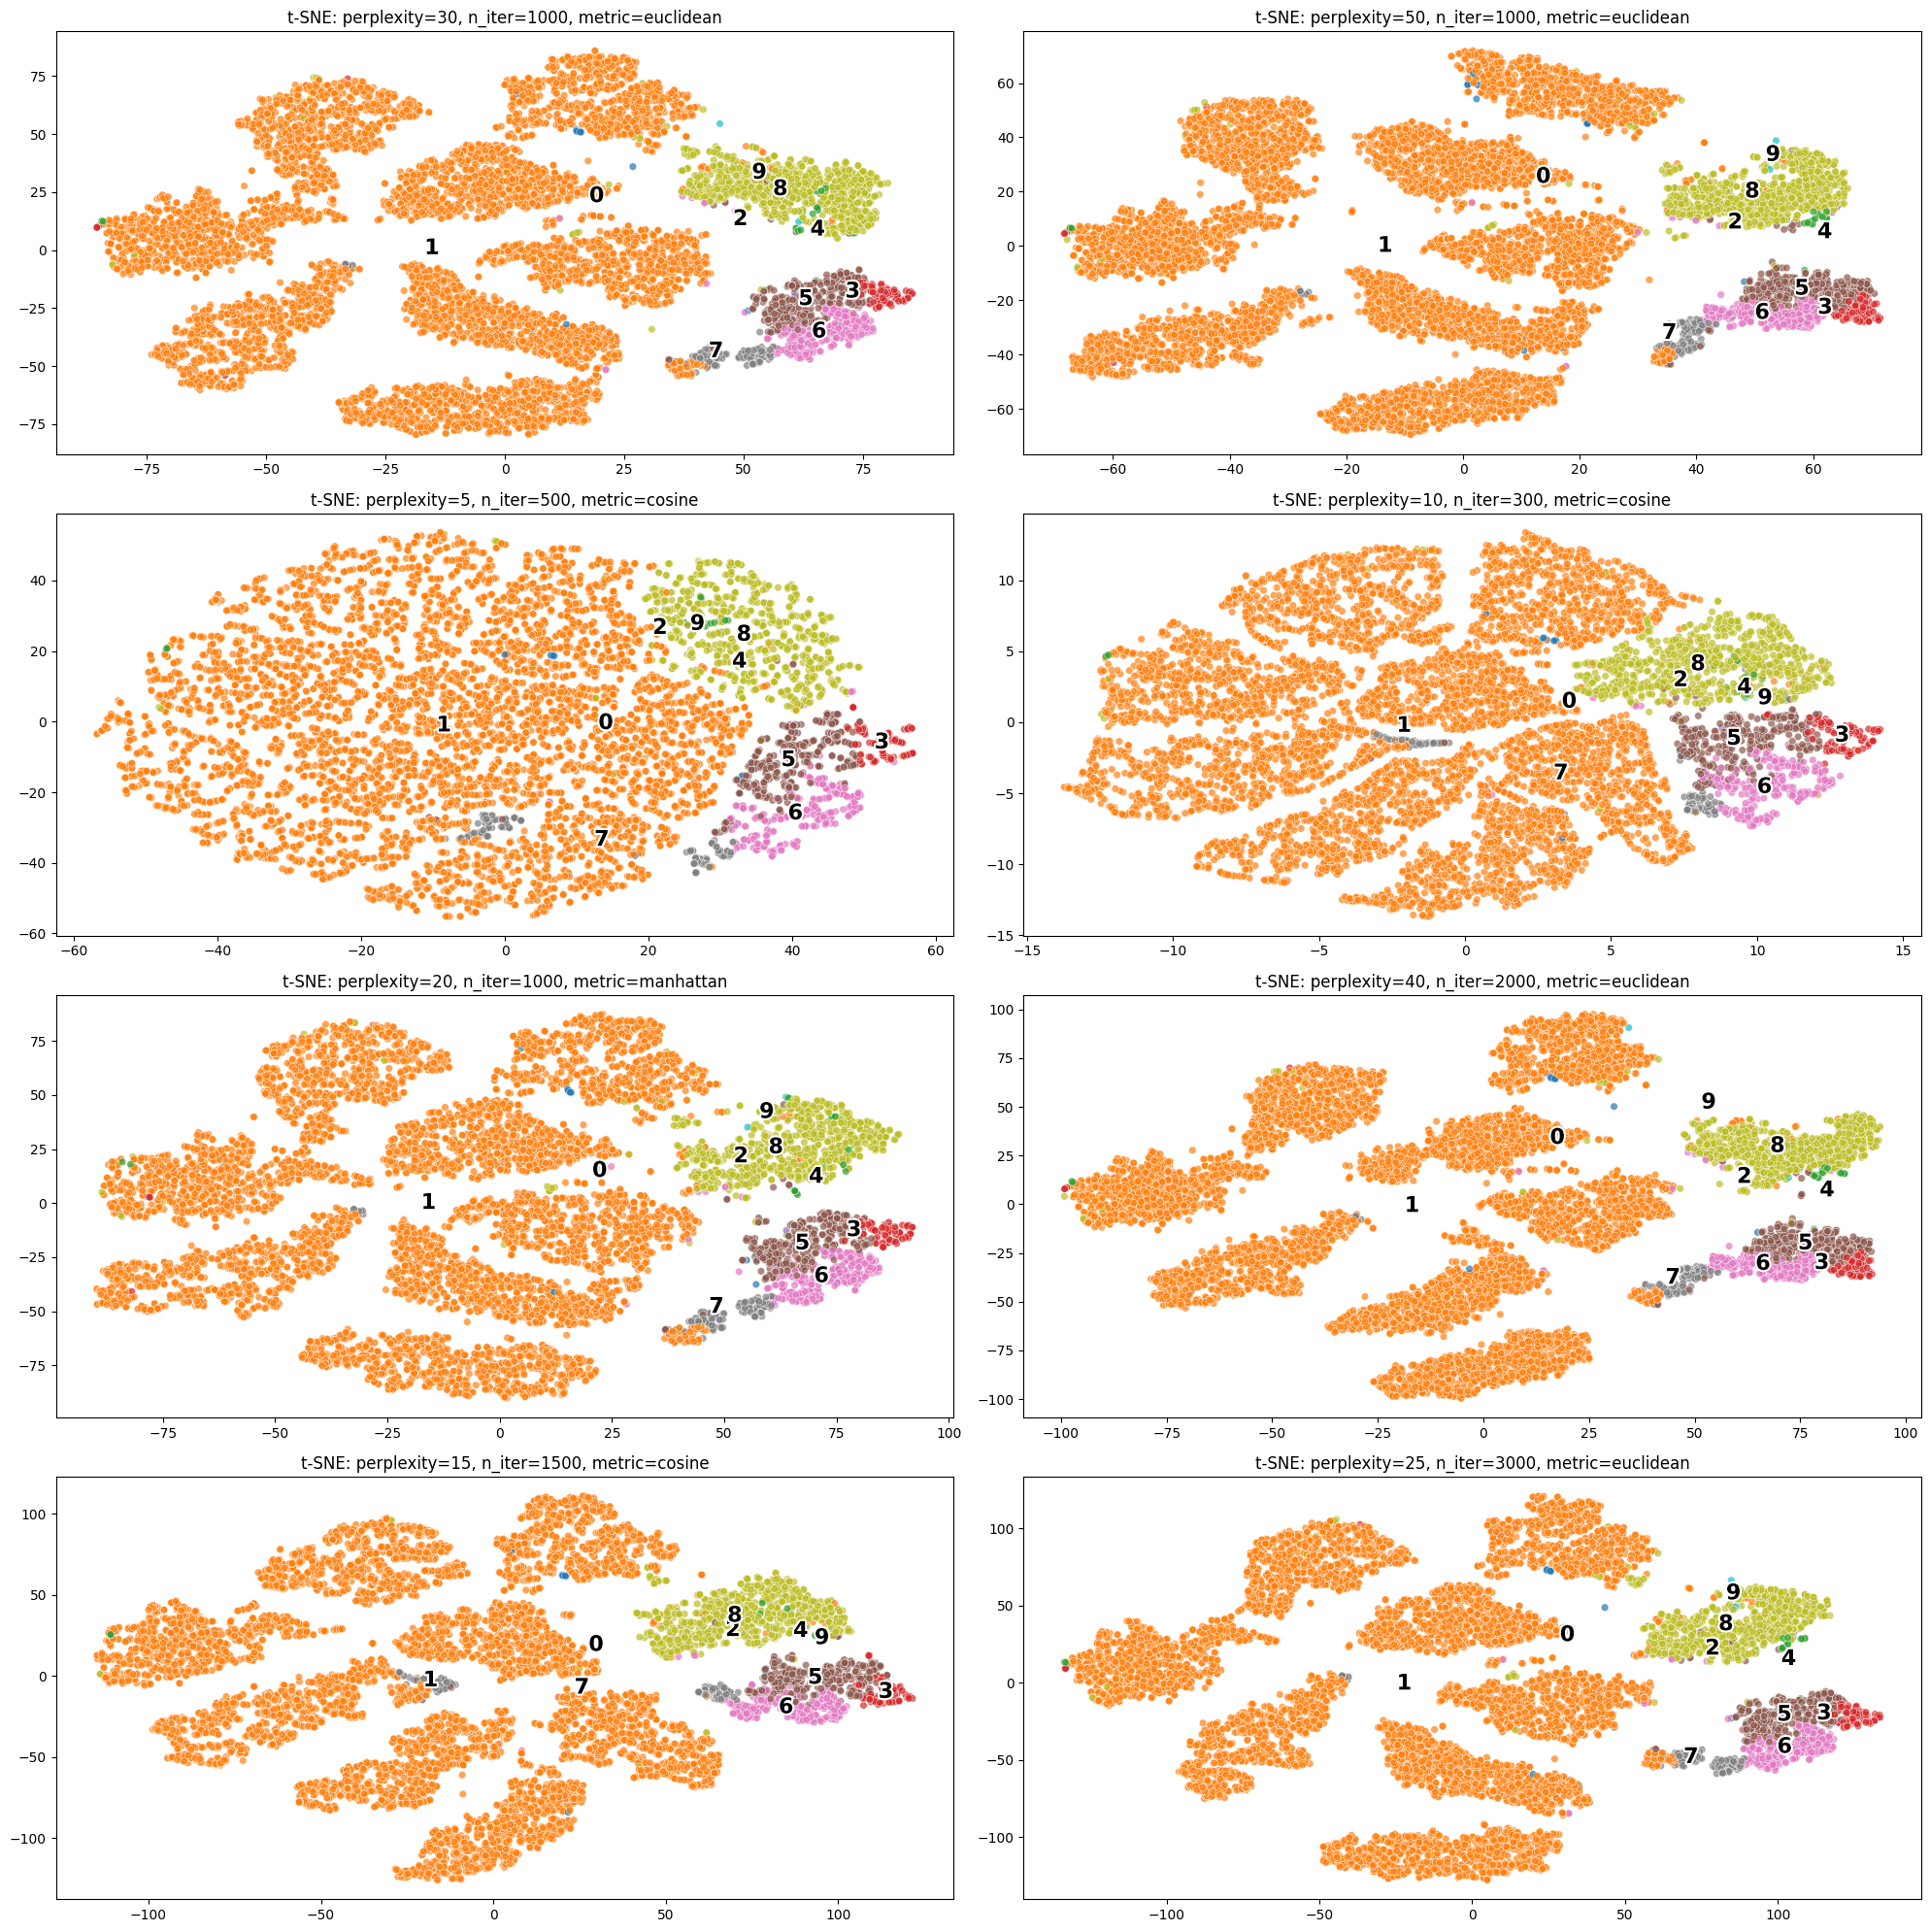

In [91]:
def plot_tsne(tsne_result, labels, config, ax):
    # Scatter plot with cluster membership as color
    sns.scatterplot(
        x=tsne_result[:, 0], y=tsne_result[:, 1], 
        hue=labels, palette='tab10', ax=ax, legend=None, s=30, alpha=0.7
    )
    ax.set_title(f"t-SNE: perplexity={config['perplexity']}, n_iter={config['n_iter']}, metric={config['metric']}")

    # Compute centroids for clusters
    n_clusters = len(np.unique(labels))
    for i in range(n_clusters):
        cluster_points = tsne_result[labels == i]
        centroid = cluster_points.mean(axis=0)
        
        # Plot Roman numerals at the centroids
        ax.text(
            centroid[0], centroid[1], f"{i + 0}", 
            fontsize=16, fontweight='bold', 
            ha='center', va='center', 
            path_effects=[withStroke(linewidth=3, foreground='white')]
        )

# Plot all the t-SNE results
fig, axes = plt.subplots(4, 2, figsize=(20, 20))  # Adjust rows/columns based on number of configurations
axes = axes.flatten()

for idx, result in enumerate(tsne_results):
    plot_tsne(result["tsne_result"], best_labels, result["config"], axes[idx])

plt.tight_layout()
plt.show()

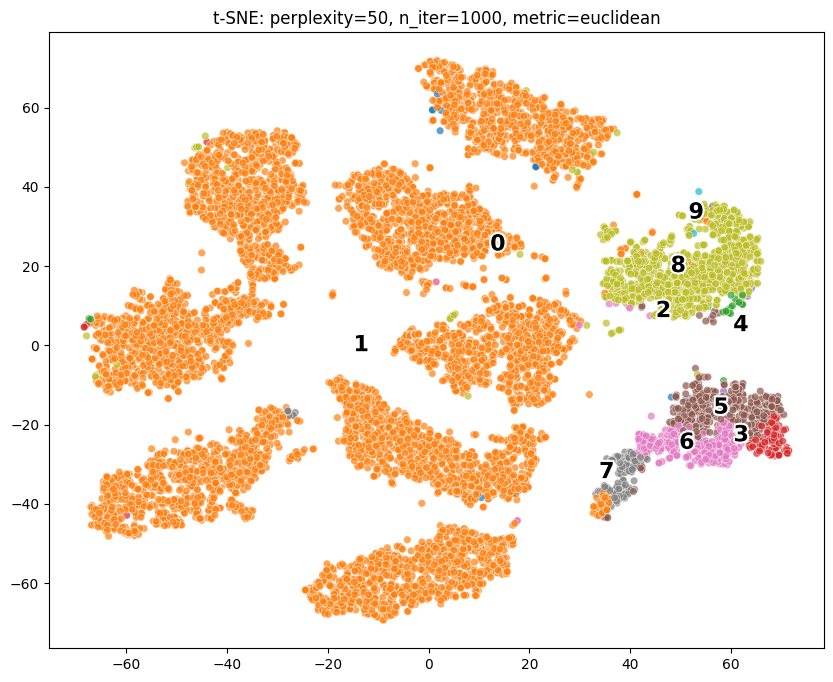

In [92]:
# Plot the best t-SNE result
tsne_result = tsne_results[1]  # Adjust index if needed
fig, ax = plt.subplots(figsize=(10, 8))

plot_tsne(tsne_result["tsne_result"], best_labels, tsne_result["config"], ax)

plt.show()

<span style="color: green">

Examining the scatter plots from the initially selected model reveals that Agglomerative Clustering tends to form one dominant cluster, likely due to its hierarchical structure, which doesn’t adequately capture the dataset’s diversity. With this in mind, it’s better to consider an alternative model. After reviewing the silhouette scores of various options, we have decided to switch to KMeans with \( k = 10 \), which should provide a more accurate representation of the dataset’s structure.

</span>

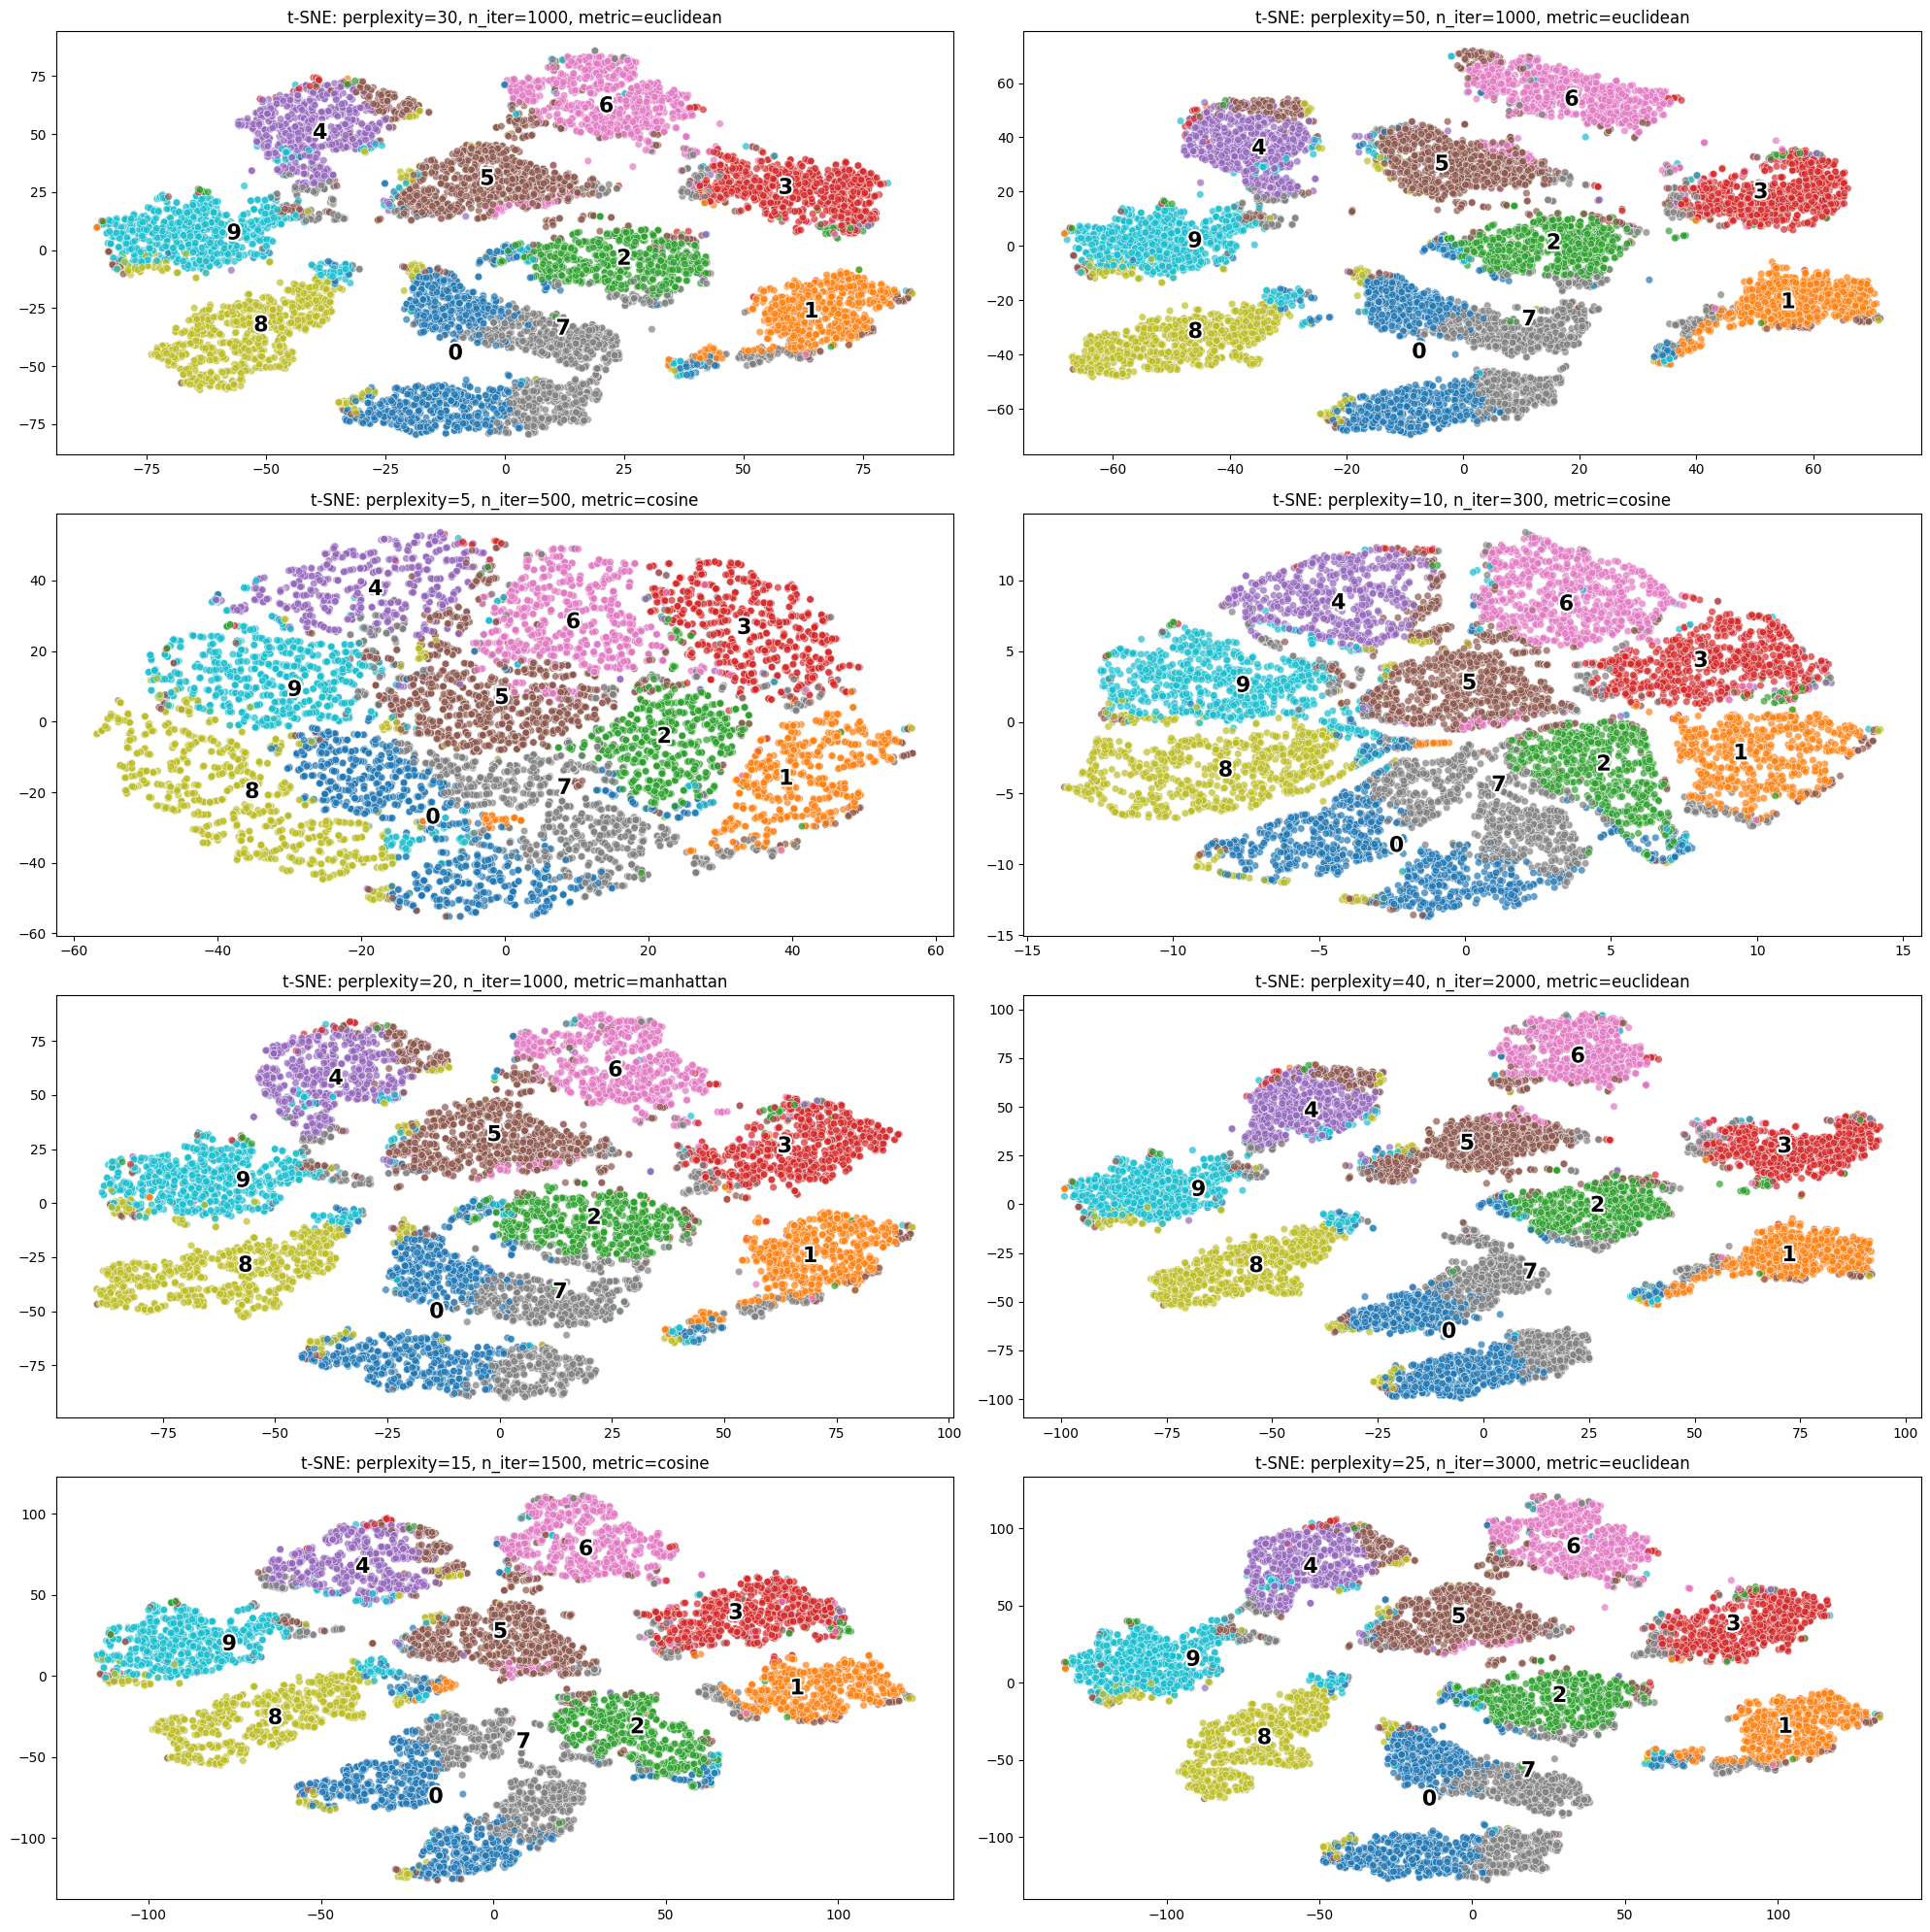

In [85]:
# Plot all the t-SNE results
fig, axes = plt.subplots(4, 2, figsize=(20, 20))  # Adjust rows/columns based on number of configurations
axes = axes.flatten()

for idx, result in enumerate(tsne_results):
    plot_tsne(result["tsne_result"], final_labels, result["config"], axes[idx])

plt.tight_layout()
plt.show()

c) Using markdown, explain which plot provides the best visualization. You may wish to revisit the clustering models in step 2 to improve your results.

<span style="color: green">

##### t-SNE with Perplexity=25, Iterations=3000, Metric=euclidean.

Reasoning:
- Stable and Well-Separated Clusters: Higher iterations (3000) give t-SNE more time to converge, resulting in distinct clusters that don’t overlap. This is particularly beneficial for complex data like digit images, where each class should ideally form a unique cluster.
- Compact and Balanced Cluster Shapes: The extra iterations help stabilize the layout, reducing random noise and making clusters more visually distinct.
- Effective Use of Euclidean Distance: With Perplexity 25, the Euclidean metric maps similar data points closer together while pushing different clusters further apart, enhancing the spatial separation that t-SNE achieves.
- Clear Visual Interpretation: Each cluster appears isolated from others, with well-defined boundaries. This makes it easier to interpret and distinguish each digit in the t-SNE plot.
- Optimal Balance of Cost and Clarity: Although 3000 iterations are computationally intensive, they strike a balance by maximizing cluster clarity without excessive overlap.

</span>

##### 4. Conclusions

a) Display again your best t-SNE plot of your best model and restate the hyperparameter choices.

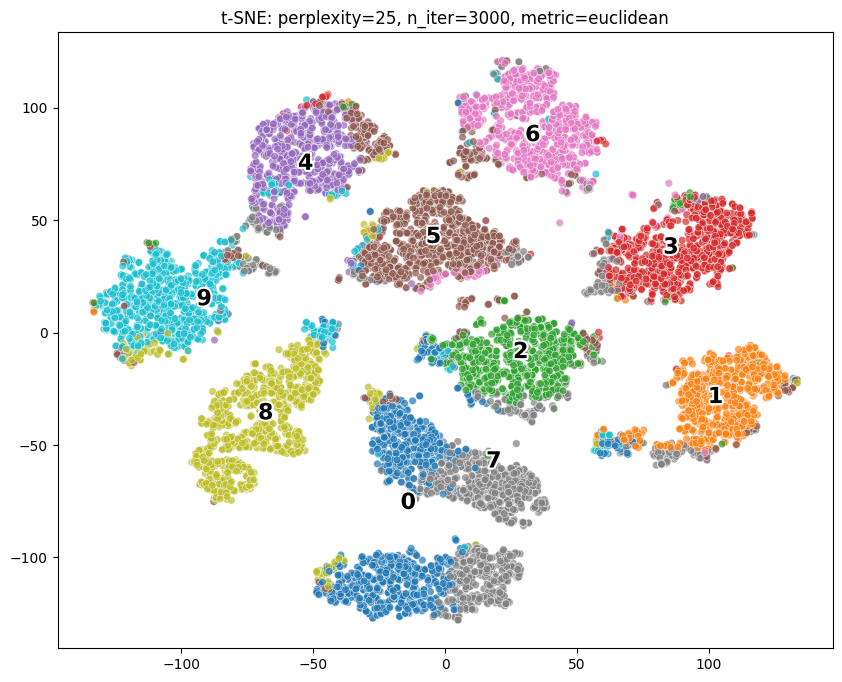

In [88]:
# Plot the best t-SNE result
best_tsne_result = tsne_results[7]  # Adjust index if needed
fig, ax = plt.subplots(figsize=(10, 8))

plot_tsne(best_tsne_result["tsne_result"], final_labels, best_tsne_result["config"], ax)

plt.show()

b) Use markdown to discuss how well suited this data is for classification. Identify any classes which may be confused by a classification model.

<span style="color: green">

The dataset is generally well-suited for classification, with most digits forming distinct and separated clusters. Digits like 1, 3, 4, 6, and 8 show clear, compact clusters, indicating strong potential for accurate classification. The t-SNE visualization shows good separation among most digit clusters, which suggests that a classification model should be able to differentiate between many classes effectively. However, there are some potential confusion points:

- 0 and 7: These clusters are close and partially overlap, which may cause misclassification between these two digits.
- 5 and 6: While separate, these clusters are relatively close, indicating a possible risk of confusion.
- 8 and 9: Minor overlap is observed, which could lead to occasional misclassification between these digits.

For improved accuracy, focus on techniques that enhance the model’s ability to distinguish between closely positioned or overlapping digit classes, such as 0 & 7, 5 & 6, and 8 & 9. Additional preprocessing or feature engineering may help reduce misclassification in these areas.
</span>